## Imports and utils

In [ ]:
!pip install -q bitsandbytes accelerate einops
!pip list | grep transformers
!pip list | grep bitsandbytes
!pip list | grep accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 4.9 MB/s eta 0:00:00
transformers                     4.42.4
bitsandbytes                     0.43.2
accelerate                       0.32.1


In [ ]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

In [ ]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig
from torchvision import transforms
import torch as t
from PIL import Image
import requests
import csv
import numpy as np
import einops
from types import MethodType

In [ ]:
def initiate_memory_logging():
    # initial timestep for defining the filename where memory values will be logged
    timestamp_0 = !nvidia-smi --query-gpu=timestamp --format=csv,noheader
    global memory_log_filename
    memory_log_filename = 'memory_log_' + timestamp_0[0].replace(' ', '_').replace('/','_') + '.txt'
    print(f'memory_log_filename: {memory_log_filename}')
    !touch $memory_log_filename

    # write device name as the first line
    gpu_name = !nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
    print(f'gpu_name: {gpu_name}')

    with open(memory_log_filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(gpu_name)

    print('Initiated memory log.')

def log_memory_usage():
    # get current GPU usage
    current_gpu_usage = !nvidia-smi --query-gpu=memory.used --format=csv,noheader
    timestamp = !nvidia-smi --query-gpu=timestamp --format=csv,noheader
    timestamp = timestamp[0].replace(' ', '_').replace('/','_')
    current_gpu_usage = [timestamp] + current_gpu_usage

    with open(memory_log_filename, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(current_gpu_usage)

In [ ]:
# function to display the image processed with LlavaNextImageProcessor
def display_processed_tiles(pixel_values: t.Tensor):
    processed_image = einops.rearrange(pixel_values, 'b t c h w -> b t h w c')
    print(processed_image.shape)

    """processed_image needs to be the output of the processor"""
    def denormalise(image, mean, std):
        return 255 * ((image * std) + mean)

    if processed_image.shape[0] == 1:
        processed_image = processed_image.squeeze(0)
    else:
        raise NotImplementedError('Batch size > 1 not implemented yet')

    for tile in range(processed_image.shape[0]):
        image = denormalise(processed_image[tile], processor_mean, processor_std)
        display(Image.fromarray(image.cpu().numpy().astype(np.uint8)))

## Load the model and tokenizer

In [ ]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda


In [ ]:
initiate_memory_logging()

memory_log_filename: memory_log_2024_07_25_15:16:18.805.txt
gpu_name: ['NVIDIA L4, 23034 MiB']
Initiated memory log.


In [ ]:
# for storing params as 4-bit numbers
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=t.float16
)

In [ ]:
log_memory_usage()

model_id = "llava-hf/llava-v1.6-vicuna-7b-hf"

# torch_dtype should be the precision of the weights of the model as stored on HF
# quantisation decreases model size, but increases inference time as the weights need to be de-quantised for each matrix multiplication
# quantisation is particularly useful for text generation, where we don't care about the exact logits, just an overall distribution that we argmax over
# note that 4-bit is slower than 8-bit because it uses a more aggressive quantisation method, so it is harder to du-quantise it at each step

model = LlavaNextForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=t.float16,
    low_cpu_mem_usage=True,
    quantization_config=quantization_config
)

# this is not needed here as BitsAndBytes automatically puts the model on device nad casts the correct dtype
# model.to(device)

log_memory_usage()

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

We want to compute the gradients only wrt to the perturbation $\delta$, not wrt the internal weights, so we switch that off here.

Note: setting the model in eval mode does not mean that gradients won't be computed.

In [ ]:
model.eval();
# t.set_grad_enabled(True)
# model.train();

if model.training:
    print('Model is in training mode')
else:
    print('Model is in eval mode')

# we're only interested in computing the gradients wrt the input images, not the internal parameters
for name, param in model.named_parameters():
    param.requires_grad = False

Model is in eval mode


Define the processor so that we can pre-process the prompt+image into a format accepted by the model. This includes a normalisation step.

In [ ]:
# processor = LlavaNextProcessor.from_pretrained(model_id, do_rescale=False) # LlavaNextImageProcessor
processor = AutoProcessor.from_pretrained(model_id, do_rescale=False) # LlavaNextImageProcessor

processor_mean = t.tensor(processor.image_processor.image_mean).to(device)
processor_std = t.tensor(processor.image_processor.image_std).to(device)
# print(processor_mean)
# print(processor_std)

tokenizer = processor.tokenizer
vocab_size = model.vocab_size

preprocessor_config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

## Inference

We should fix a universal size of an image so that we can train a single adversarial perturbation. Llava-v1.6 is based on CLIP-ViT-L-336px, so I choose a size below that resolution

In [ ]:
universal_img_size = (256, 256)

Prepare the text prompt, using the appropriate prompt template:

In [ ]:
prompt = ["A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>\nWhat is shown in this image? ASSISTANT:"]

# I write everything in lists to prepare the code for batch inputs in the future
prompt_tokenized = [tokenizer.encode(p) for p in prompt]
len_prompt_tokenized = [len(item) for item in prompt_tokenized]

print(len_prompt_tokenized)
batch_size = len(prompt)
print(f'batch_size: {batch_size}')

[49]
batch_size: 1


Now prepare the image prompts, initialise $\delta$ and transform: $x' = x + ɛ \,\delta$.

In [ ]:
url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = [Image.open(requests.get(url, stream=True).raw)]
image = [img.resize(universal_img_size) for img in image]

to_tensor = transforms.ToTensor()

image_tensor = [to_tensor(img).to(device) for img in image]

delta = t.zeros_like(image_tensor[0], requires_grad=True, device=device)

# l-\infty norm
eps = 8/255

perturbed_image_tensor = [(img_tensor + eps * delta.clamp(-1, 1)).clamp(0, 1).to(device) for img_tensor in image_tensor]

Finally, use the processor to prepare the inputs to the model.
The output is a dictionary of four items:
- `input_ids` - token ids of the text prompt
- `attention_mask` - if processing a batch input, text prompts need to be of the same length. They are padded with 0s (by default on the right). The attention mask tells the model which tokens are legitimate and should be attended to (denoted with '1') and which ones are just for padding and should be ignored (denoted with '0').
- `pixel_values` - processed images, shape: `[batch, patch, channel, height, width]`, where `patch` is because Llava is based on CLIP-ViT-L-336px and it does some weird thing with padding - even images smaller than 336x336 will be split into 3 patches of size 336x336
- `image_size` - original image sizes

In [ ]:
# padding=True to enable batch processing of prompts with different lengths
inputs = processor(prompt, perturbed_image_tensor, return_tensors="pt", padding=True).to(device)
inputs.pixel_values.requires_grad = True
# dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_sizes'])

In [ ]:
inputs.pixel_values.shape

torch.Size([1, 3, 3, 336, 336])

Now define the target token which we want to force the model to predict using the adversarial perturbation.

In [ ]:
# Trump token - chosen arbitrarily
# print(tokenizer.encode('Trump'))
# tokenizer.decode(27504)

target = ["Trump"]
target_tokenized = [tokenizer.encode(t) for t in target]
target_tokenized = t.tensor(target_tokenized).to(device)

torch.Size([1, 3, 336, 336, 3])


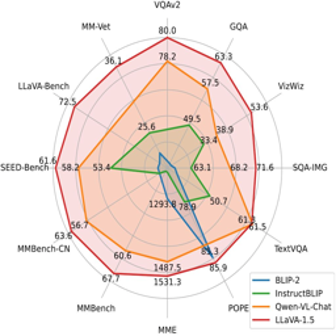

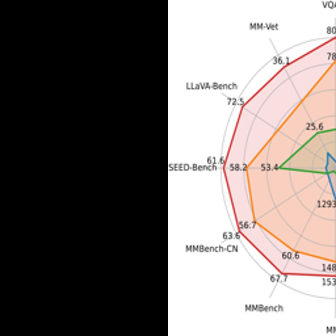

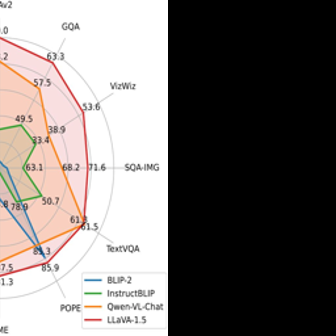

In [ ]:
# use this to display the processed image that has been split into patches:
display_processed_tiles(inputs.pixel_values.clone().detach());

Now, finally do the forward pass:

In [ ]:
# Not sure if t.enable_grad() makes any difference
# Not sure if I should use True or False for the cache here. I think it should be False at least when we're just doing one pass to generate one token.
with t.enable_grad():
    output = model.forward(
        **inputs,
        return_dict=True,
        output_hidden_states=False,
        output_attentions=False,
        use_cache=False,
        )

    logits = output.logits # [batch, sequence_position, vocab]
    next_token_logits = logits[:, -1] # [batch, vocab]
    print(next_token_logits.shape)
    next_token_pred = tokenizer.batch_decode(next_token_logits.argmax(-1), skip_special_tokens=True)
    print(next_token_pred)

    loss_fn = t.nn.CrossEntropyLoss()
    loss_fn.requires_grad = True # not sure why I need to include this line
    loss = loss_fn(next_token_logits, target_tokenized[:, -1])
    # loss.requires_grad=True
    print(loss)

    model.zero_grad()
    loss.backward()

torch.Size([1, 32064])
['The']
tensor(25.0155, device='cuda:0', grad_fn=<NllLossBackward0>)


So, we can call `loss.backward()` without an error. While the gradients of the image *after* it has been processed by the processor are calculated, the gradients of the $\delta$ perturbation are `None`, because this tensor was created *before* the processor.

I am 98% sure that the processor does something that detaches tensors from the computational graph, but I don't know how to fix it.

In [ ]:
print(inputs.pixel_values.grad.data.shape)
print(delta.grad.data) # <-- this returns None

t.cuda.empty_cache()
log_memory_usage()

torch.Size([1, 3, 3, 336, 336])


AttributeError: 'NoneType' object has no attribute 'data'

In [ ]:
# print(t.cuda.max_memory_allocated() / 1024**3) # MiB
# t.cuda.reset_peak_memory_stats()

In [ ]:
!cp $memory_log_filename drive/MyDrive/pivotal_files/memory_logs